# Case Study III: (1) Solving Laplace's equation with Python

In the first part of the case study we will solve a simple electrostatics problem with Python. In the second part, we will use NumPy.

## Solving Laplace's or Poisson's equation

**Poisson's equation** for the electric potential $\Phi(\mathbf{r})$ and the charge density $\rho(\mathbf{r})$:

$$
\nabla^2 \Phi(x, y, z) = -4\pi\rho(x, y, z)\\
$$

For a region of space without charges ($\rho = 0$) this reduces to **Laplace's equation**

$$
\nabla^2 \Phi(x, y, z) = 0
$$


Solutions depend on the **boundary conditions**: 

* the *value of the potential* on the *boundary* or 
* the *electric field* (i.e. the derivative of the potential, $\mathbf{E} = -\nabla\Phi$ *normal to the surface* ($\mathbf{n}\cdot\mathbf{E}$), which directly follows from the charge distribution).

### Example: 2D Laplace equation for the "Wire on the grounded box" problem

As a problem. consider a grounded box where the left side is a wire held at a potential of 100 V. There are no charges _inside_ the box.

![Wire on a grounded box](wire_box.png)

Boundary conditions:
* square area surrounded by wires
* three wires at ground (0 V), one wire at 100 V (the line with $x=0$ is at 100 V)

_Inside the box_ the **Laplace equation** applies: 
$$
\frac{\partial^2 \Phi(x,y)}{\partial x^2} + \frac{\partial^2 \Phi(x,y)}{\partial y^2} = 0
$$

i.e., the Poisson equation with charges set to 0.

## Finite difference algorithm for Poisson's equation
Discretize space on a lattice (2D) and solve for $\Phi$ on each lattice site.

Taylor-expansion of the four neighbors of $\Phi(x, y)$:

\begin{align}
\Phi(x \pm \Delta x, y) &= \Phi(x, y) \pm \Phi_x \Delta x + \frac{1}{2} \Phi_{xx} \Delta x^2 + \dots\\
\Phi(x, y \pm \Delta y) &= \Phi(x, y) \pm \Phi_y \Delta x + \frac{1}{2} \Phi_{yy} \Delta x^2 + \dots\\
\end{align}

Add equations in pairs: odd terms cancel, and **central difference approximation** for 2nd order partial derivatives (to $\mathcal{O}(\Delta^4)$):

\begin{align}
\Phi_{xx}(x,y) = \frac{\partial^2 \Phi}{\partial x^2} & \approx 
  \frac{\Phi(x+\Delta x,y) + \Phi(x-\Delta x,y) - 2\Phi(x,y)}{\Delta x^2} \\
\Phi_{yy}(x,y) = \frac{\partial^2 \Phi}{\partial y^2} &\approx 
  \frac{\Phi(x,y+\Delta y) + \Phi(x,y-\Delta y) - 2\Phi(x,y)}{\Delta y^2}
\end{align}

Take $x$ and $y$ grids of equal spacing $\Delta$: Discretized Poisson equation

$$
\begin{split}
\Phi(x+\Delta x,y) + \Phi(x-\Delta x,y) +\Phi(x,y+\Delta y) &+ \\
   +\, \Phi(x,y-\Delta y) - 4\Phi(x,y) &= -4\pi\rho(x,y)\,\Delta^2
   \end{split}
$$

Defines a system of $N_x \times N_y$ simultaneous algebraic equations for $\Phi_{ij}$ to be solved.

Can be solved directly via matrix approaches (and then is the best solution) but can be unwieldy for large grids.

Alternatively: **iterative solution**:

$$
\begin{split}
4\Phi(x,y) &= \Phi(x+\Delta x,y) + \Phi(x-\Delta x,y) +\\
 &+ \Phi(x,y+\Delta y) + \Phi(x,y-\Delta y) + 4\pi\rho(x,y)\,\Delta^2
\end{split}
$$

Compute a new value for $\Phi(x,y)$ (left hand site) from a guessed potential (right hand side).

Or written for lattice sites $(i, j)$ where 

$$
x = x_0 + i\Delta\quad\text{and}\quad y = y_0 + j\Delta, \quad 0 \leq i,j < N_\text{max}
$$

$$
\Phi_{i,j} = \frac{1}{4}\Big(\Phi_{i+1,j} + \Phi_{i-1,j} + \Phi_{i,j+1} + \Phi_{i,j-1}\Big)
     + \pi\rho_{i,j} \Delta^2
$$

* Converged solution at $(i, j)$ will be the average potential from the four neighbor sites + charge density contribution.
* *Not a direct solution*: iterate and hope for convergence.

#### Jacobi method
Do not change $\Phi_{i,j}$ until a complete sweep has been completed.

The Jacobi algorithm is the simplest iterative approach and much better solutions exist (which we explore in the PHY432 _Computational Methods_ class). Jacobi converges slower than better algorithms but it will eventually give the right answer. It has the advantage of being easier to understand and easier to speed up with NumPy.

## Solution via relaxation (Jacobi method) in Python

Solve the box-wire problem on a lattice: The wire at $x=0$ (the $y$-axis) is at 100 V, the other three sides of the box are grounded (0 V).

Note: $\rho=0$ inside the box.

Note for Jupyter notebook use:
* For interactive 3D plots, select
  ```
  %matplotlib notebook
  ```
* For standard inline figures (e.g. for exporting the notebook to LaTeX/PDF or html) use 
  ```
  %matplotlib inline
  ```  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib inline
%matplotlib notebook

In [2]:
%matplotlib inline

#### Wire on a box: Solution of Laplace's equation with the Jacobi algorithm

The potential is represented as a numpy array `Phi[x, y]`. We will consider axis 0 to correspond to x and axis 1 to y. (Technically speaking, row indices are "x" and column indices are "y" but this becomes confusing when translating the equations into code. We just need to be careful when we plot...)

We only iterate to `Max_iter = 70`: this will *not* produce a converged solution. We will address this problem in the second part.

Note how the actual update of the array does not update the boundaries of the array because they are set by the problem. It also means that the indices loop over `Nmax-2` values via `range(1, Nx-1)` and `range(1, Ny-1)`. This is important to remember for the numpyfication in Part 2.


In [3]:
Nmax = 100
Max_iter = 70
Phi = np.zeros((Nmax, Nmax), dtype=np.float64)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

# Jacobi: do not change the potential during one update, so we need to work on a copy
Phi_new = Phi.copy()

Nx, Ny = Phi.shape
for n_iter in range(Max_iter):
    for xi in range(1, Nx-1):
        for yj in range(1, Ny-1):
            Phi_new[xi, yj] = 0.25*(Phi[xi+1, yj] + Phi[xi-1, yj] 
                                 + Phi[xi, yj+1] + Phi[xi, yj-1])
    # update the potential for the next iteration
    Phi[:, :] = Phi_new

#### Visualization of the potential 

We use 2D and 3D plotting in matplotlib. The meshgrid function provides a convenient way to produce arrays that can be easily plotted with these functions. The notebook [meshgrid.ipynb](meshgrid.ipynb) provides additional information.

In [4]:
# plot Phi(x,y)
x = np.arange(Phi.shape[0])
y = np.arange(Phi.shape[1])
X, Y = np.meshgrid(x, y)

Z = Phi[X, Y]

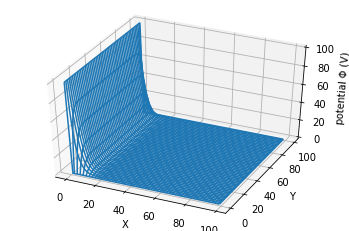

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'potential $\Phi$ (V)')

ax.view_init(elev=40, azim=-65)

Nicer plot (you can use this code for other projects):

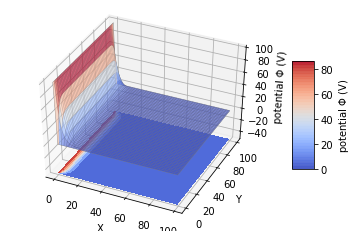

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, linewidth=0.5, color="gray")
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, alpha=0.6)
cset = ax.contourf(X, Y, Z, zdir='z', offset=-50, cmap=plt.cm.coolwarm)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'potential $\Phi$ (V)')
ax.set_zlim(-50, 100)
ax.view_init(elev=40, azim=-65)

cb = fig.colorbar(surf, shrink=0.5, aspect=5)
cb.set_label(r"potential $\Phi$ (V)")

(Note that the calculation above is is *not converged* ... see next lecture.)